# Introduction

This notebook demonstrates a Bayesian inference and Maximum Entropy (MaxEnt) approach to build an allometric model, enabling us to estimate biomass from specific site measurements, including height, diameter at breast height (DBH), and other relevant metrics. Allometric models are widely used in ecological and forestry studies to estimate biomass based on more accessible field measurements. However, traditional models may lack the flexibility to handle missing observations or may fail to account for the uncertainty inherent in biomass estimation.

Here, we integrate Bayesian inference with Maximum Entropy principles to address these limitations, yielding a model that:

- **Captures Uncertainty:** Bayesian inference provides a probabilistic framework that quantifies the uncertainty in our biomass predictions. This allows us to better understand the range of possible outcomes given the variability and noise within our data.

- **Accommodates Missing Observations:** Our model is designed to handle incomplete data, where measurements may be missing for some parameters. By leveraging the Bayesian framework, we can account for these gaps without discarding valuable site information, improving the model's robustness and generalizability.

- **Extracts Allometric Relationships:** Using a MaxEnt approach, we can infer the most probable relationships between variables based on the available measurements. MaxEnt is particularly useful here because it provides a principled way to estimate probability distributions under constraints, enabling us to incorporate our prior knowledge while remaining data-driven.

The model will take in measurements from different sites and output allometric relationships with associated uncertainty bounds, offering insights into the biomass distribution across different forest stands or ecosystems. This approach holds significant value in ecological research, where understanding biomass dynamics is essential for carbon stock assessments, biodiversity monitoring, and forest management.


## Load libraries


In [1]:
import matplotlib.pyplot as plt

import numpy  as np
import pandas as pd
import math
import numbers

import pytensor.tensor as tt
import pymc  as pm
import arviz as az

from pdb import set_trace

## Load up data

In [2]:
file = 'data/SH_allometry_2023.csv'

In [3]:
df = pd.read_csv(file)

In [4]:
df['h_mean'] = df[['h1', 'h2', 'h3']].mean(axis=1)
df['h_std'] = df[['h1', 'h2', 'h3']].std(axis=1)
df['d_mean'] = df[['d1', 'd2', 'd3']].mean(axis=1)
df['d_std'] = df[['d1', 'd2', 'd3']].std(axis=1)

## Visualisation sanity check of data

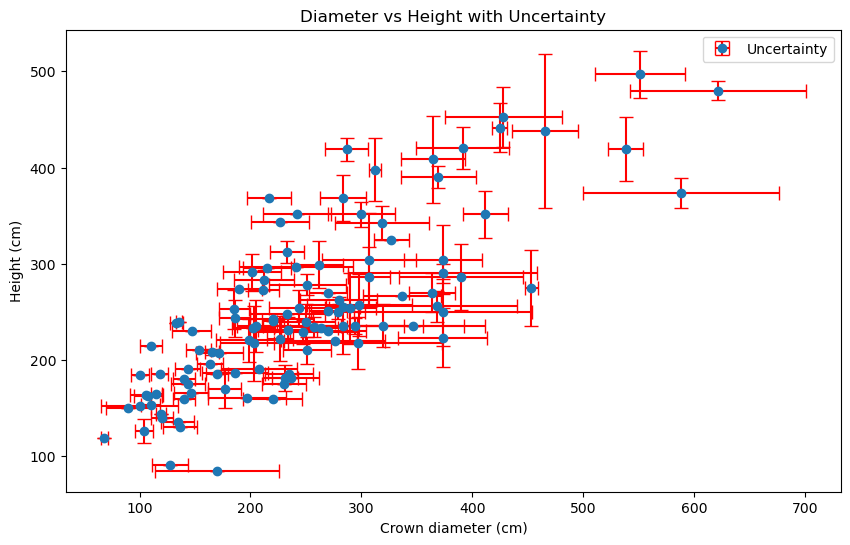

In [46]:
plt.figure(figsize=(10, 6))
plt.errorbar(df['d_mean'], df['h_mean'], xerr=df['d_std'], yerr=df['h_std'], fmt='o', ecolor='r', capsize=5, label='Uncertainty')
plt.xlabel('Crown diameter (cm)')
plt.ylabel('Height (cm)')
plt.title('Diameter vs Height with Uncertainty')
plt.legend()

## Define models

In [44]:
def exp_allomotry(X, params, inference = False):
    if inference:
        numPCK =  __import__('pytensor').tensor
    else:
        numPCK =  __import__('numpy')
    
    return numPCK.sum(X * params['betas'] + params['beta0'] , axis = 1)
    

## make fake_data

In [7]:
params_True = {'betas': np.array([2, 3]),
               'beta0': 1}
X = df[['h_mean', 'd_mean']].values
Y_fake = exp_allomotry(X, params_True) + np.random.lognormal(0.0, 1.0, size=X.shape[0])
df['Y_fake'] = Y_fake

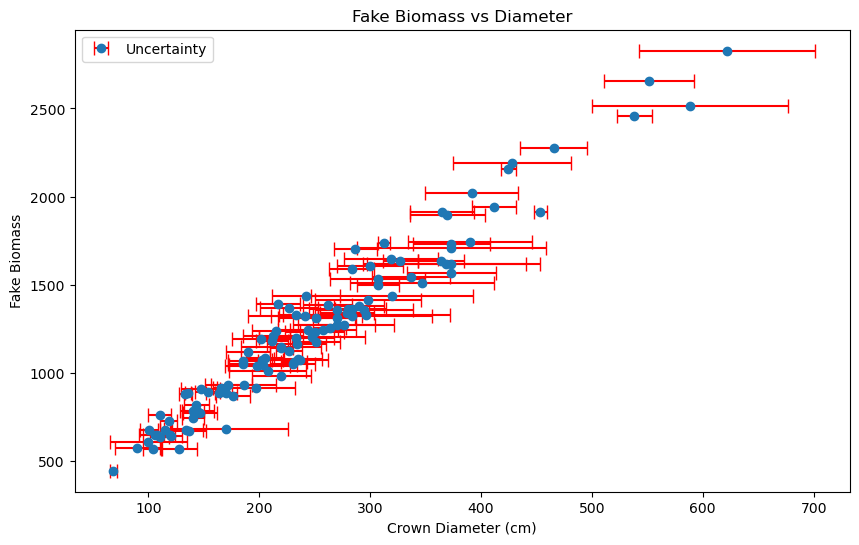

In [47]:
plt.figure(figsize=(10, 6))
plt.errorbar(df['d_mean'], df['Y_fake'], xerr=df['d_std'], fmt='o', ecolor='r', capsize=5, label='Uncertainty')
plt.xlabel('Crown Diameter (cm)')
plt.ylabel('Fake Biomass')
plt.title('Fake Biomass vs Diameter')
plt.legend()


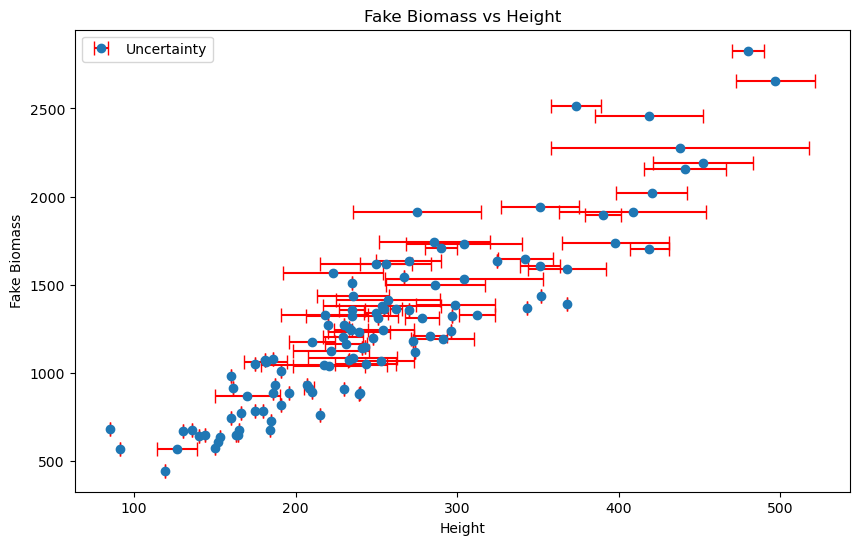

In [9]:
plt.figure(figsize=(10, 6))
plt.errorbar(df['h_mean'], df['Y_fake'], xerr=df['h_std'], fmt='o', ecolor='r', capsize=5, label='Uncertainty')
plt.xlabel('Height(cm)')
plt.ylabel('Fake Biomass')
plt.title('Fake Biomass vs Height')
plt.legend()


## Optimise

In [10]:
def MaxEnt(Y, fx):
    fx = 1 - tt.exp(-fx)
    Y = 1 - tt.exp(-Y)
    return Y*tt.log(fx) + (1.0-Y)*tt.log((1-fx))

In [11]:
with pm.Model() as max_ent_model:
    ## set priors
    nvars = X.shape[1]
    params = {'betas': pm.LogNormal('betas', mu = 0, sigma = 1, shape = nvars),
              'beta0': pm.Normal('beta0', mu = 0, sigma = 1, shape = 1)}
    prediction = exp_allomotry(X, params, True)
    
    error = pm.DensityDist("error", prediction,
                                   logp = MaxEnt, 
                                   observed = df['Y_fake'])
    trace = pm.sample(100, return_inferencedata=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, beta0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
params_opt = {'betas':trace.posterior['betas'].values, 'beta0': trace.posterior['beta0'].values}

In [27]:
M, N = params_opt['beta0'].shape[0:2]
N

100

In [37]:
M, N = params_opt['beta0'].shape[0:2]

simulation_results = np.zeros((len(X), M, N))

# Run the simulations
for m in range(M):
    for n in range(N):
        param_dict = {'betas': params_opt['betas'][m, n, :], 'beta0': params_opt['beta0'][m, n, 0]}
        simulation_results[:, m, n] = exp_allomotry(X, param_dict)

# Calculate the mean and standard deviation of the simulations for each row in X
simulation_means = simulation_results.mean(axis=(1, 2))
simulation_stds = simulation_results.std(axis=(1, 2))
percentile_10 = np.percentile(simulation_results, 10, axis=(1, 2))
percentile_90 = np.percentile(simulation_results, 90, axis=(1, 2))

# Add the percentile range to the DataFrame
df['simulation_10'] = percentile_10
df['simulation_90'] = percentile_90

# Add the mean and std to the DataFrame
df['simulation_mean'] = simulation_means
df['simulation_std'] = simulation_stds

In [35]:
df['simulation_std']

0      1064.144385
1      1149.338789
2      1248.035673
3       826.066460
4      1093.187007
          ...     
105     756.243455
106     548.246730
107    1922.478669
108    1050.967602
109     892.965999
Name: simulation_std, Length: 110, dtype: float64

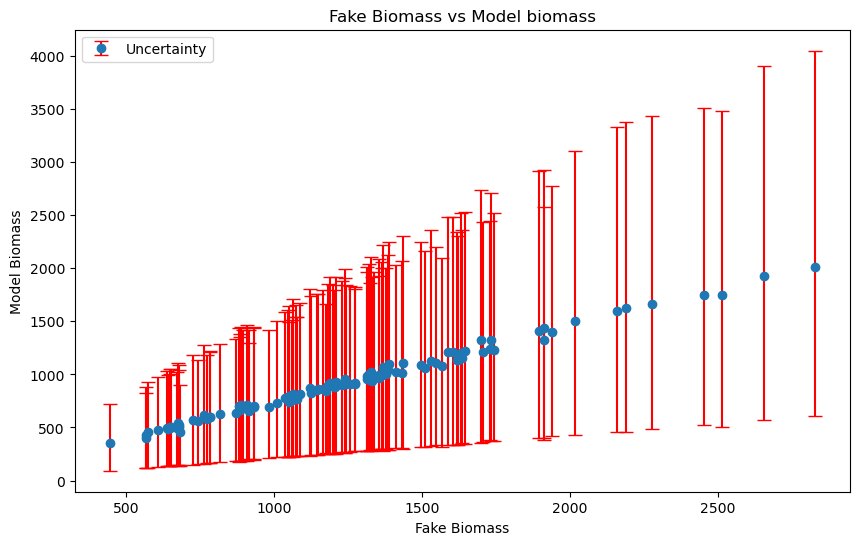

In [43]:
plt.figure(figsize=(10, 6))
plt.errorbar(df['Y_fake'], df['simulation_mean'], yerr=[df['simulation_mean'] - df['simulation_10'], df['simulation_90'] - df['simulation_mean']], fmt='o', ecolor='r', capsize=5, label='Uncertainty')
plt.xlabel('Fake Biomass')
plt.ylabel('Model Biomass')
plt.title('Fake Biomass vs Model biomass')
plt.legend()
